Extracting input/data/train-images-idx3-ubyte.gz
Extracting input/data/train-labels-idx1-ubyte.gz
Extracting input/data/t10k-images-idx3-ubyte.gz
Extracting input/data/t10k-labels-idx1-ubyte.gz
9999                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

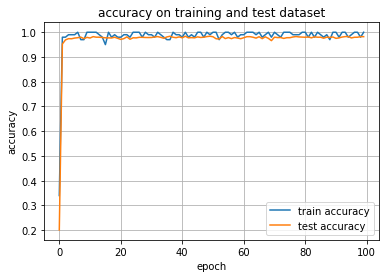

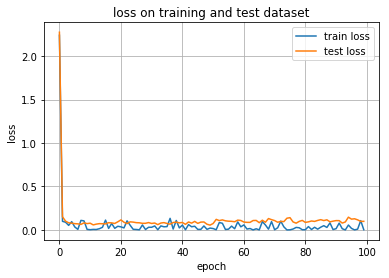

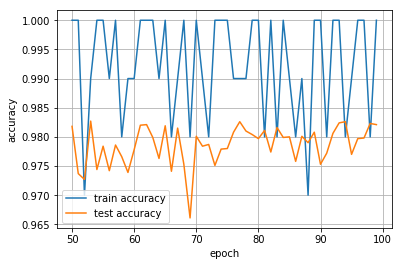

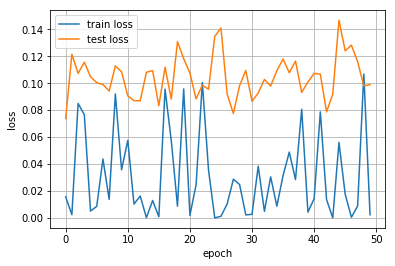

In [32]:
# all tensorflow api is accessible through this
import tensorflow as tf        
# to visualize the resutls
import matplotlib.pyplot as plt 
# 70k mnist dataset that comes with the tensorflow container
from tensorflow.examples.tutorials.mnist import input_data


IMAGE_SIZE = 28
NUM_CHANNELS = 1

tf.set_random_seed(0)

# load data
mnist = input_data.read_data_sets('input/data', one_hot=True)


# 1. Define Variables and Placeholders

# Computation graph by creating nodes for the input images and target output classes.
X = tf.placeholder(tf.float32, [None, IMAGE_SIZE*IMAGE_SIZE*NUM_CHANNELS])
Y_ = tf.placeholder(tf.float32, [None, 10])

#learning rate placeholder
# It is often recommended to lower the learning rate as the training progresses. 
# This function applies an exponential decay function to a provided initial learning rate.
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.01
lr = tf.train.exponential_decay(starter_learning_rate, global_step, 100000, 0.90, staircase=True)

# placeholder for probability of keeping a node during dropout = 1.0 
# at test time (no dropout) and 0.75 at training time
# Dropout layers provide a simple way to avoid overfitting. 
# The primary idea is to randomly drop components of neural network (outputs) from a layer of neural network. 
# This results in a scenario where at each layer more neurons are forced to learn the 
# multiple characteristics of the neural network.
pkeep = tf.placeholder(tf.float32)

# 2. Define the model for defined activation function (ReLU)

def weight_variable(shape):
    #define weight variable for a convolutional layer
    #W_I = tf.Variable(tf.truncated_normal([<patch_height>, <patch_width>, <input_channels>, <output_channels>], ⤦
    # stddev=0.1))
    # Weights initialised with small random values between -0.2 and +0.2
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.zeros(shape)
    return tf.Variable(initial)

def apply_activation_with_dropout(Y, W, B, keep_prob):
    #define convolutional layer in model
    # Create activation function of input Y
    activation=tf.nn.relu(tf.matmul(Y, W) + B)
        
    # apply dropout to hidden layer
    out_layer = tf.nn.dropout(activation, keep_prob)
        
    return out_layer

def apply_activation_without_dropout(Y, W, B):
    #define convolutional layer in model
    # Create activation function of input Y
    out_layer=tf.nn.relu(tf.matmul(Y, W) + B)
        
    return out_layer

def conv_act(x, W, B, stride):
    out = tf.nn.relu(tf.nn.conv2d(x, W, strides=stride, padding='SAME') + B)
    return tf.nn.max_pool(out, ksize=[1, 1, 1, 1], strides=[1, 1, 1, 1], padding='SAME')

# Build graph of activation functions

# Reshape to use within a convolutional neural net.
# Last dimension is for "features" - there is only one here, since images are
XX = tf.reshape(X, [-1, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS])
                    
# First convolutional layer - maps to 4 feature maps.  
W1 = weight_variable([5, 5, 1, 4])
B1 = bias_variable([4])
Y1 = conv_act(XX, W1, B1, [1, 1, 1, 1])                   
       
# Second convolutional layer - maps 4 to 8 feature maps.                 
W2 = weight_variable([5, 5, 4, 8])
B2 = bias_variable([8])
Y2 = conv_act(Y1, W2, B2, [1, 2, 2, 1])      
                    
# Third convolutional layer - maps 8 to 12 feature maps with 4x4 patch                
W3 = weight_variable([4, 4, 8, 12])
B3 = bias_variable([12])
Y3 = conv_act(Y2, W3, B3, [1, 2, 2, 1])   
      
# Fully connected layer 
W4 = weight_variable([IMAGE_SIZE/4*IMAGE_SIZE/4*12, 200])
B4 = bias_variable([200])
Y3_flat = tf.reshape(Y3, [-1, IMAGE_SIZE/4*IMAGE_SIZE/4*12])

# two different activations (with/without) dropout should be used
#Y4 = apply_activation_without_dropout(Y3_flat, W4, B4)
Y4 = apply_activation_with_dropout(Y3_flat, W4, B4, pkeep)                

# Last layer is softmax to ensure that the sum of the components of output vector is equal to 1
W5 = weight_variable([200, 10])
B5 = bias_variable([10])
Ylogits = tf.matmul(Y4, W5) + B5
Y = tf.nn.softmax(Ylogits)

# 3. Define the loss function
# Get total loss over all the training instances, calculate cross-entropy with logits
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_))

# 4. Define the accuracy 
is_correct = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

# 5. Define an optimizer - automatic differentiation to realize backpropagation

# 5.1 Just gradied descent optimizer -> does not work
#optimizer = tf.train.GradientDescentOptimizer(starter_learning_rate)
#train_step = optimizer.minimize(cross_entropy)

# 5.2 Adam optimizer -> 0.5 does not work, 0.1 does not work, 0.01 works with 0.97 avg accuracy
optimizer = tf.train.AdamOptimizer(starter_learning_rate)
train_step = optimizer.minimize(cross_entropy)

# 5.3 Adam optimizer with learning rate decay -> works with 0.98 avg accuracy 
optimizer = tf.train.AdamOptimizer(lr)
train_step = optimizer.minimize(cross_entropy, global_step=global_step)

# 5.3 Adam optimizer with learning rate decay and dropout -> works with 0.98 avg accuracy 
optimizer = tf.train.AdamOptimizer(lr)
train_step = optimizer.minimize(cross_entropy, global_step=global_step)

# initialize
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

def training_step(i, update_test_data, update_train_data):

    print "\r", i,
    ####### actual learning 
    # reading batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)
    # the backpropagation training step with 0.75 dropout
    sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y, pkeep: 0.75})
    
    ####### evaluating model performance for printing purposes
    # evaluation used to later visualize how well you did at a particular time in the training
    train_a = []
    train_c = []
    test_a = []
    test_c = []
    if update_train_data:
        # test step with 1 dropout (no dropout)
        a, c = sess.run([accuracy, cross_entropy], feed_dict={X: batch_X, Y_: batch_Y, pkeep: 1})
        train_a.append(a)
        train_c.append(c)

    if update_test_data:
        # test step with 1 dropout (no dropout)
        a, c = sess.run([accuracy, cross_entropy], feed_dict={X: mnist.test.images, Y_: mnist.test.labels, pkeep: 1})
        test_a.append(a)
        test_c.append(c)

    
    return (train_a, train_c, test_a, test_c)

# 6. Train and test the model, store the accuracy and loss per iteration

train_a = []
train_c = []
test_a = []
test_c = []
    
training_iter = 10000
epoch_size = 100
for i in range(training_iter):
    test = False
    if i % epoch_size == 0:
        test = True
    a, c, ta, tc = training_step(i, test, test)
    train_a += a
    train_c += c
    test_a += ta
    test_c += tc

# 7. Plot and visualise the accuracy and loss

# accuracy training vs testing dataset
plt.title("accuracy on training and test dataset")
plt.plot(train_a, label = "train accuracy")
plt.plot(test_a, label = "test accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# loss training vs testing dataset
plt.title("loss on training and test dataset")
plt.plot(train_c, label = "train loss")
plt.plot(test_c, label = "test loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Zoom in on the tail of the plots
zoom_point = 50
x_range = range(zoom_point,training_iter/epoch_size)
plt.plot(x_range, train_a[zoom_point:], label = "train accuracy")
plt.plot(x_range, test_a[zoom_point:], label = "test accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

plt.plot(train_c[zoom_point:], label = "train loss")
plt.plot(test_c[zoom_point:], label = "test loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc="best")
plt.grid(True)
plt.show()